# Poiseuille - BGK - Zou-He Constant Velocity Inlet and Outlet

In [1]:
# Python Imports
from pylab import *
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors
from IPython.display import display, Math, Latex

## Setting Simulation

### Lattice Paremeters

In [2]:
w0=4.0/9.0;w1=1.0/9.0;w2=1.0/36.0; # Lattice Weights
w = np.array([w0,w1,w1,w1,w1,w2,w2,w2,w2],dtype="float64") 
cx = np.array([0,1,0,-1, 0,1,-1,-1, 1],dtype="int8")  # Lattice Directions
cy = np.array([0,0,1, 0,-1,1, 1,-1,-1],dtype="int8")  # Lattice Directions
opp = np.array([0,3,4,1,2,7,8,5,6],dtype="uint8")  # Opposite Lattice Directions

### Problem Scaling: From Dimensionless to LBM Scale

In [3]:
#------------Dimensionless Parameter For Pro----------------
uo = 1.0 # Dimensionless Velocity
ho = 1.0 # Dimensionless Domain Length
Re = 10.0 # Reynolds Number
nuo = uo*ho/Re #Dimensionless Kinematic Viscosity

The problem scaling follow the equations:
$$
\Delta x=\frac{H_{0}}{Nx}, \quad \quad r=\frac{\Delta x}{\Delta t}, \quad \quad u=u_{0}\frac{\Delta t}{\Delta x}, \quad \quad \textrm{and} \quad \quad \nu=\nu_{0}\frac{\Delta t}{\Delta x^{2}}
$$
where $\Delta x $ is grid size, $\Delta y$ is time step and $r$ is the relation term. Dimensionless numbers
$$
Re=\frac{u_{0}\rho H}{\mu}=\frac{u_{0} H}{\nu} \quad \quad \textrm{and} \quad \quad C_{d}=\frac{24}{Re}\frac{L}{H}.
$$

In [4]:
import time
#---------------Numerical Domain Size--------------------
cases=3
Nx0 = np.array([10, 20, 40],dtype="int64")
Ny0 = np.array([12, 22, 42],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
mstep=10000
mstep0 = np.array([mstep*4**(0), mstep*4**(1), mstep*4**(2)],dtype="int64")
rhor = np.empty(len(Nx0), dtype=object)
Vxr = np.empty(len(Nx0), dtype=object)
Vyr = np.empty(len(Nx0), dtype=object)
Cdr = np.zeros((3),dtype="float64")
Mass = np.empty(len(Nx0), dtype=object)
for i in range(len(Nx0)):
    rhor[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Vxr[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Vyr[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Mass[i] = np.zeros((int(mstep0[i])), dtype="float64")
for case in range(0,cases):
    Nx=Nx0[case]
    Ny=Ny0[case]
    #------------------------------------------Scaling Term--------------------------------------------
    dx = ho / (Ny-2) # Grid size 
    r = r0[case] # Relation term r=dx/dt
    dt = dx / r # Time Step
    #----------------------------------------LBM-Scale-----------------------------------------------
    nu = dt * nuo / (dx * dx)  #Scaling Viscosity
    ue = dt * uo / dx  #Scaling Velocity
    cs = 1.0 / sqrt(3.) #Sound Speed
    tau = (nu/ (cs * cs)) + (1.0/ 2.0) #Relaxation time
    rhoi = 1.0 #Initial Densty
    #--------------Print-Data-------------------------------------------------------------------------
    display(Math(r"\tau="+str(tau)+r"\quad\quad \nu="+str(nu)))
    display(Math(r"r="+str(r)+r"\quad\quad \overline{u}="+str(ue)))
    display(Math(r"dx="+str(dx)+r"\quad\quad dt="+str(dt)))
    #----------------Allocating array of solid nodes------------------------------------------------
    solid=np.ones((Nx,Ny),dtype="uint8") # Binary array to allocate the mapp of pore and solid # Parallel Plates
    solid[:,0] = 0
    solid[:,Ny-1] = 0
    #--------Allocating "imapp" array ti store the information of lattice directions that need be 
    # inverted during the Half-way Bounce-Back method.
    imapp=np.zeros((9,Nx,Ny),dtype="uint8") #Interface mapping for Half-Way Bounce-Back
    for i in range(0,Nx):
        for j in range (0, Ny):
            if (solid[i,j]==1):
                for k in range (0,9):
                    #-----------------------------------------
                    ii=i+cx[k] 
                    if (ii>Nx-1):ii=0
                    if (ii<0):ii=Nx-1
                    #-----------------------------------------
                    jj=j+cy[k] 
                    if (jj>Ny-1):jj=0
                    if (jj<0):jj=Ny-1
                    #-----------------------------------------
                    if (solid[ii,jj]==0):
                        imapp[k,i,j]=k
    #---------------------Field-Arrays---------------------------------------------------------------- 
    rho=np.zeros((Nx,Ny),dtype="float64") # Allocating Density field
    rho[:,:]=np.where(solid==1,rhoi,0.0) # Constant initial density field
    rhow=np.zeros((Ny),dtype="float64") # Allocating West Boundary Density
    rhoe=np.zeros((Ny),dtype="float64") # Allocating East Boundary Density
    up=np.zeros((Ny),dtype="float64") # Allocating Boundary Parabolic Profile
    y=np.linspace(0.5, Ny-2 -0.5, Ny-2)
    up[1:-1]=6.0 * ue * ( y/float(Ny - 2) - ( y/float(Ny - 2) )**2 );
    Vx=np.zeros((Nx,Ny),dtype="float64") # Allocating Null Velocity x Field
    Vy=np.zeros((Nx,Ny),dtype="float64") # Allocating Null Velocity y Field
    #----------------Initializing Distribution Functions----------------
    f=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pre-Collisional Distribution Function
    fp=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pos-Collisional Distribution Function
    feq=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pos-Collisional Distribution Function
    for k in range (0,9):
        f[k,:,:]=np.where(solid==1,w[k]*rho[:,:],0.0)
    #---------------------------------Main-Loop-------------------------------------------------------
    Cd=0.0; Cd0=0.0
    tolerance=0.000001
    start=time.time()
    #---------------------------------Main-Loop-------------------------------------------------------------------------------------
    for kk in range(0,mstep0[case]):
        #------------------------------------Collision-----------------------------------------------------------------------------
        for k in range(0,9):
            feq[k,:,:]=w[k]*rho*(1. + 3.*(Vx*cx[k]+Vy*cy[k]) + 4.5*(Vx*cx[k]+Vy*cy[k])**2-1.5*(Vx*Vx+Vy*Vy))
            fp[k,:,:]=np.where(solid==1, f[k,:,:]-(1.0/tau)*(f[k,:,:]-feq[k,:,:]), 0.0 )
        #----------------------------------Streaming---------------------------------------------------------------------------
        for k in range(0,9):
            f[k,:,:]=np.roll(np.roll(fp[k,:,:], cx[k], axis=0), cy[k], axis=1)
        #--------------------------------------Half-Way-------------------------------------------------------------------------
        for k in range(1,9):
            f[k,:,:]=np.where(imapp[opp[k],:,:]==opp[k],fp[opp[k],:,:],f[k,:,:])
        #--------------------------------------Zou-He-BC------------------------------------------------------------------------
        #--------------------Inlet------------------------------------------------------------
        rhow= (f[0,0,:] + f[2,0,:] + f[4,0,:] + 2 * (f[3,0,:] + f[6,0,:] +f[7,0,:]) )/(1.0-up)
        f[1,0,:] = f[3,0,:] + 2.0*rhow*up/3.0
        f[5,0,:] = f[7,0,:] - (f[2,0,:]-f[4,0,:])/2.0 + rhow*up/6.0
        f[8,0,:] = f[6,0,:] + (f[2,0,:]-f[4,0,:])/2.0 + rhow*up/6.0
        #--------------------Outlet (2ndOrd)------------------------------------------------------------
        k_list = [3, 6, 7]
        f[k_list, Nx-1, :] = 2*f[k_list, Nx-2, :] - f[k_list, Nx-3, :]

        #--------------------------------------Macro-Properties------------------------------------------------------------------
        rho=np.where(solid==1,np.einsum('ixy->xy', f),0.0) 
        Vx=np.divide(np.einsum('i,ixy->xy', cx, f), rho, out=np.zeros_like(Vx, dtype="float64"), where=rho!=0)
        Vy=np.divide(np.einsum('i,ixy->xy', cy, f), rho, out=np.zeros_like(Vy, dtype="float64"), where=rho!=0)
        #-------------------------------------Convergence------------------------------------------------------------------------
        rho_med = np.sum(rho)/(Nx*(Ny-2))
        Mass[case][kk] = rho_med
        if (kk%1000==0):
            Umed = np.sum(Vx)/(Nx*(Ny-2))
            rho_med = np.sum(rho)/(Nx*(Ny-2))
            dp = (sum(rho[0,:]) - sum(rho[Nx-1,:]))*cs**2/(Ny-2)
            Cd=dp/(rho_med*Umed**2/2.0)
            print('Da=',Cd,'\t Diff=',np.fabs(Cd-Cd0),'\t Umed=',Umed,'\t Erro=',np.fabs(Cd-24.0/Re))
            # if(np.fabs(Cd-Cd0)<tolerance):
            #     break
            Cd0=Cd
    Cdr[case]=Cd
    rhor[case]=rho
    Vxr[case]=Vx
    Vyr[case]=Vy

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 616.0614643928451 	 Diff= 616.0614643928451 	 Umed= 0.012562499999999999 	 Erro= 613.6614643928451
Da= 2.223976146890395 	 Diff= 613.8374882459547 	 Umed= 0.12857796072581926 	 Erro= 0.176023853109605
Da= 2.227481905945019 	 Diff= 0.0035057590546241357 	 Umed= 0.12870169770535514 	 Erro= 0.17251809405498086
Da= 2.227548059222375 	 Diff= 6.615327735604026e-05 	 Umed= 0.12870403226147997 	 Erro= 0.17245194077762482
Da= 2.2275493154134782 	 Diff= 1.2561911031383488e-06 	 Umed= 0.12870407659247682 	 Erro= 0.17245068458652169
Da= 2.227549339270349 	 Diff= 2.38568707011666e-08 	 Umed= 0.12870407743438653 	 Erro= 0.17245066072965098
Da= 2.2275493397233617 	 Diff= 4.530127384327898e-10 	 Umed= 0.12870407745037202 	 Erro= 0.17245066027663825
Da= 2.2275493397320245 	 Diff= 8.662848216545171e-12 	 Umed= 0.12870407745067627 	 Erro= 0.1724506602679754
Da= 2.227549339732159 	 Diff= 1.3455903058456897e-13 	 Umed= 0.1287040774506803 	 Erro= 0.17245066026784084
Da= 2.227549339732318 	 Diff= 1.58983

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 4592.988091112738 	 Diff= 4592.988091112738 	 Umed= 0.0031289062499999997 	 Erro= 4590.588091112739
Da= 2.281933372798821 	 Diff= 4590.70615773994 	 Umed= 0.06263453476958153 	 Erro= 0.11806662720117878
Da= 2.2964271203082296 	 Diff= 0.014493747509408461 	 Umed= 0.062931344253407 	 Erro= 0.10357287969177031
Da= 2.2987357365367354 	 Diff= 0.0023086162285057554 	 Umed= 0.06297845028462029 	 Erro= 0.10126426346326456
Da= 2.2991085805872964 	 Diff= 0.00037284405056103864 	 Umed= 0.06298605372128877 	 Erro= 0.10089141941270352
Da= 2.299168929940994 	 Diff= 6.0349353697475294e-05 	 Umed= 0.06298728432000102 	 Erro= 0.10083107005900604
Da= 2.299178701750641 	 Diff= 9.771809647229901e-06 	 Umed= 0.06298748357653063 	 Erro= 0.10082129824935882
Da= 2.2991802841011992 	 Diff= 1.582350558138046e-06 	 Umed= 0.06298751584209646 	 Erro= 0.10081971589880068
Da= 2.2991805403350103 	 Diff= 2.562338110578821e-07 	 Umed= 0.06298752106691823 	 Erro= 0.10081945966498962
Da= 2.299180581826871 	 Diff= 4.1

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 35426.73692315072 	 Diff= 35426.73692315072 	 Umed= 0.0007814941406249998 	 Erro= 35424.33692315072
Da= 2.3124980083802464 	 Diff= 35424.42442514234 	 Umed= 0.030961999635640183 	 Erro= 0.08750199161975347
Da= 2.329141682058513 	 Diff= 0.01664367367826669 	 Umed= 0.03112148654362214 	 Erro= 0.07085831794148678
Da= 2.3362852454122045 	 Diff= 0.007143563353691373 	 Umed= 0.031208138987451117 	 Erro= 0.06371475458779541
Da= 2.340240147746058 	 Diff= 0.003954902333853649 	 Umed= 0.03125524441434791 	 Erro= 0.05975985225394176
Da= 2.3424002046010295 	 Diff= 0.0021600568549713373 	 Umed= 0.03128094248301687 	 Erro= 0.05759979539897042
Da= 2.343582595669558 	 Diff= 0.0011823910685286876 	 Umed= 0.03129499472403155 	 Erro= 0.056417404330441734
Da= 2.3442303917211857 	 Diff= 0.0006477960516275694 	 Umed= 0.03130268900555378 	 Erro= 0.055769608278814164
Da= 2.3445854609433665 	 Diff= 0.0003550692221807594 	 Umed= 0.03130690504790102 	 Erro= 0.055414539056633405
Da= 2.344780130260499 	 Diff= 

Da= 2.3450164945852716 	 Diff= 2.212452443473012e-12 	 Umed= 0.031312021811522074 	 Erro= 0.054983505414728295
Da= 2.3450164945810883 	 Diff= 4.18332035678759e-12 	 Umed= 0.03131202181152091 	 Erro= 0.054983505418911616
Da= 2.345016494577327 	 Diff= 3.76143560743003e-12 	 Umed= 0.03131202181151642 	 Erro= 0.05498350542267305
Da= 2.3450164945820213 	 Diff= 4.694467037325012e-12 	 Umed= 0.03131202181151486 	 Erro= 0.054983505417978584
Da= 2.345016494584895 	 Diff= 2.873701276939755e-12 	 Umed= 0.031312021811513074 	 Erro= 0.05498350541510488
Da= 2.34501649458983 	 Diff= 4.935163389063746e-12 	 Umed= 0.03131202181151978 	 Erro= 0.05498350541016972
Da= 2.345016494587693 	 Diff= 2.1374013670083514e-12 	 Umed= 0.03131202181152187 	 Erro= 0.05498350541230712
Da= 2.3450164945830303 	 Diff= 4.6624926142158074e-12 	 Umed= 0.031312021811527826 	 Erro= 0.054983505416969614
Da= 2.3450164945799123 	 Diff= 3.1179503423572896e-12 	 Umed= 0.03131202181153168 	 Erro= 0.054983505420087564
Da= 2.345016494

Da= 2.345016494575632 	 Diff= 8.904432746703606e-12 	 Umed= 0.03131202181152205 	 Erro= 0.054983505424367696
Da= 2.345016494582109 	 Diff= 6.476597036453313e-12 	 Umed= 0.03131202181150659 	 Erro= 0.0549835054178911
Da= 2.3450164945773047 	 Diff= 4.804157072157977e-12 	 Umed= 0.031312021811507204 	 Erro= 0.054983505422695256
Da= 2.345016494578736 	 Diff= 1.4312995233467518e-12 	 Umed= 0.0313120218114934 	 Erro= 0.054983505421263956
Da= 2.3450164945823317 	 Diff= 3.595790332155957e-12 	 Umed= 0.03131202181149063 	 Erro= 0.054983505417668166
Da= 2.3450164945775045 	 Diff= 4.827249711070181e-12 	 Umed= 0.031312021811489406 	 Erro= 0.054983505422495416
Da= 2.345016494576943 	 Diff= 5.613287612504791e-13 	 Umed= 0.03131202181148257 	 Erro= 0.054983505423056744
Da= 2.345016494579466 	 Diff= 2.5228708011582057e-12 	 Umed= 0.03131202181149924 	 Erro= 0.054983505420533874
Da= 2.345016494575581 	 Diff= 3.884892407768348e-12 	 Umed= 0.03131202181147891 	 Erro= 0.054983505424418766
Da= 2.345016494

Text(0, 0.5, '$Y$')

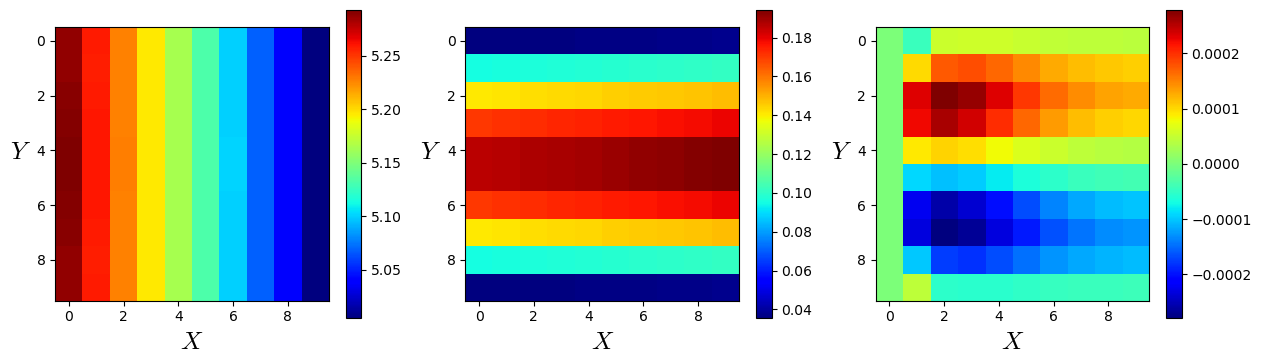

In [5]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
fig1, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(15,4))
img1=ax1.imshow(np.rot90(rhor[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img1, ax=ax1)
ax1.set_xlabel('$X$',fontsize=18)
ax1.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0)
img2=ax2.imshow(np.rot90(Vxr[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img2, ax=ax2)
ax2.set_xlabel('$X$',fontsize=18)
ax2.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 
img3=ax3.imshow(np.rot90(Vyr[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img3, ax=ax3)
ax3.set_xlabel('$X$',fontsize=18)
ax3.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 

In [6]:
Nx0 = np.array([10, 20, 40],dtype="int64")
Ny0 = np.array([12, 22, 42],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
Vxana = np.empty(len(Nx0), dtype=object)
for i in range(len(Nx0)):
    Vxana[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
for i in range(len(Nx0)):
    y=np.linspace(0.5, Ny0[i]-2 -0.5, Ny0[i]-2) / float(Ny0[i] - 2)
    for ix in range(Nx0[i]):
        Vxana[i][ix,1:-1]=6.0 * (1.0/r0[i]) * ( y - ( y )**2 );

Text(0, 0.5, '$Y$')

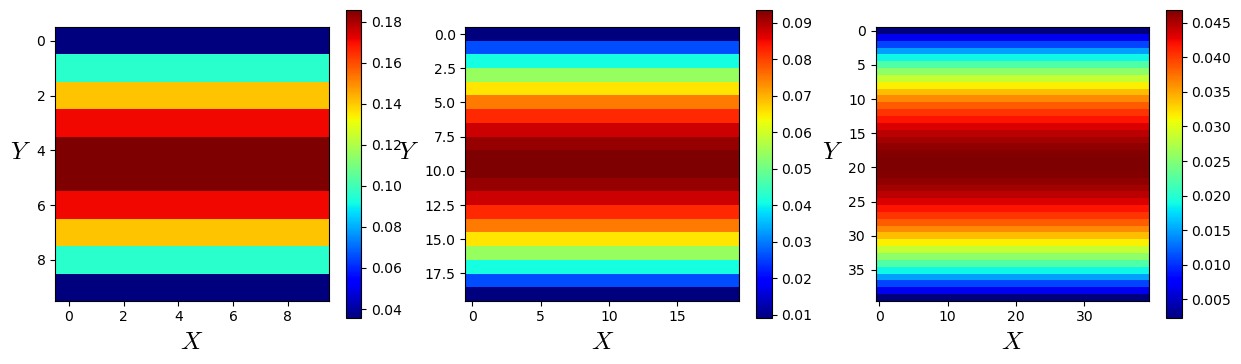

In [7]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
fig1, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(15,4))
img1=ax1.imshow(np.rot90(Vxana[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img1, ax=ax1)
ax1.set_xlabel('$X$',fontsize=18)
ax1.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0)
img2=ax2.imshow(np.rot90(Vxana[1][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img2, ax=ax2)
ax2.set_xlabel('$X$',fontsize=18)
ax2.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 
img3=ax3.imshow(np.rot90(Vxana[2][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img3, ax=ax3)
ax3.set_xlabel('$X$',fontsize=18)
ax3.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 

In [8]:
E0=sqrt(sum((Vxr[0][:,:]-Vxana[0][:,:])**2))/sqrt(sum((Vxana[0][:,:])**2))
E1=sqrt(sum((Vxr[1][:,:]-Vxana[1][:,:])**2))/sqrt(sum((Vxana[1][:,:])**2))
E2=sqrt(sum((Vxr[2][:,:]-Vxana[2][:,:])**2))/sqrt(sum((Vxana[2][:,:])**2))

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_46860/2903882536.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta x$',fontsize=16)


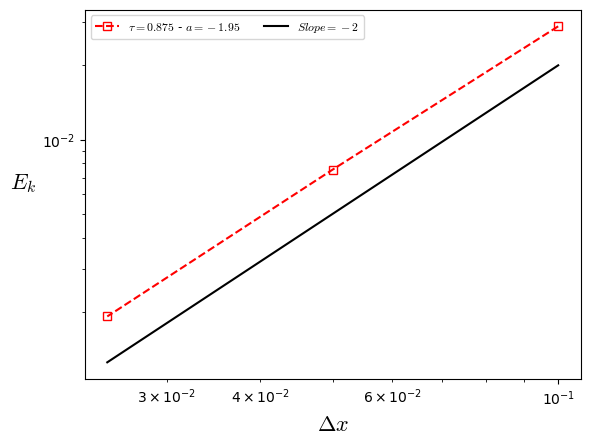

In [9]:
Malha=np.array([10,20,40])
Ek = np.array([E0,E1,E2])
TEk=np.polyfit(np.log(Malha), np.log(Ek), 1)
# Ek1 = np.array([0.000885053175400552,0.0002657329674660147,7.199195200913167e-05,1.8693115438450647e-05])
# TEk1=np.polyfit(np.log(Malha), np.log(Ek1), 1)
plt.loglog(1/Malha,Ek,'rs--',fillstyle='none')
# plt.loglog(1/Malha,Ek1,'bs--',fillstyle='none')
plt.loglog(1/Malha,2.0*1.0/(Malha**2),'k-',fillstyle='none')
plt.ylabel('$E_{k}$',fontsize=16,rotation=0,horizontalalignment='right')
plt.xlabel('$\Delta x$',fontsize=16)
plt.legend([fr'$\tau=0.875$ - $a={TEk[0]:.2f}$','$Slope=-2$'],loc=2,ncol=3,fontsize=8.5)

<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_46860/3887496154.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\overline{M}$',fontsize=16,rotation=0,horizontalalignment='right')


Text(0.5, 0, '$t$')

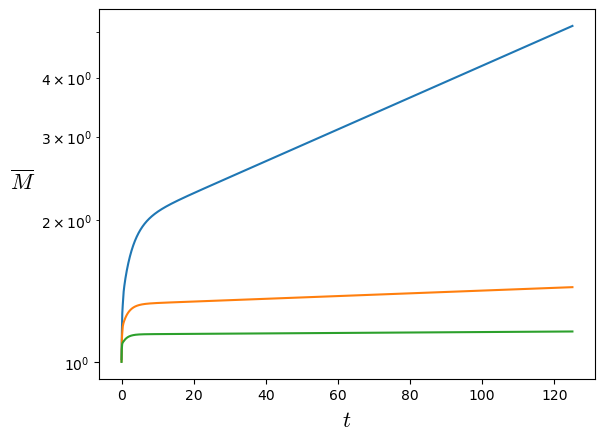

In [10]:
Nx0 = np.array([10, 20, 40],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
plt.semilogy(np.linspace(0,len(Mass[0]),len(Mass[0]))/Nx0[0]/r0[0],Mass[0])
plt.plot(np.linspace(0,len(Mass[1]),len(Mass[1]))/Nx0[1]/r0[1],Mass[1])
plt.plot(np.linspace(0,len(Mass[2]),len(Mass[2]))/Nx0[2]/r0[2],Mass[2])
plt.ylabel('$\overline{M}$',fontsize=16,rotation=0,horizontalalignment='right')
plt.xlabel('$t$',fontsize=16)